TODO HACKDAVIS DAY 2 (INORDER)
- Normalise the data/Figure out the outliers
  - Boxplots are funky
  - Histograms like the from the lecture (Three colorful shifted histograms)
- Clean up code according to ".h" file in google docs

# Setup


## Import Packages

In [4]:
### KEEP THIS

import csv # lib for reading csvs
import pandas as pd #for processing data into a DataFrame.
import matplotlib.pyplot as plt #for plotting.
%pip install tensorflow

import tensorflow as tf

import seaborn as sns
#dont care about these for now.
import numpy as np #for numerical processing.
from sklearn.linear_model import LogisticRegression #a type of classification model.
from sklearn.model_selection import train_test_split #function useful to split data into (train|test) splits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler #scaling values.
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score



  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load Data

In [5]:
### KEEP THIS

# Load the data
solar_data = pd.read_csv("solar_weather_data.csv")

#drop the first 3 columns
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)

# Get collumn names
solar_data_columns = solar_data.columns

# Convert time column from epoch ms to hour in day (ie 16 or 5) with time zone pacific
solar_data['time'] = pd.to_datetime(solar_data['time'], unit='ms')
solar_data['time'] = solar_data['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
solar_data['time'] = solar_data['time'].dt.hour

#print(type(solar_data))
pd.set_option('display.width', 1000)
print(solar_data.head(10))
print("\n")

   time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
0    18        28.1  46.6     71.63     0.0           0          0.2              62           4.9  55.6        1          17
1    19        15.8  45.7     76.61     0.0           0          0.1              14          -6.3  52.8        0           0
2    20         8.7  47.8     85.89     0.0           0          0.1               0         -17.9  51.9        0           0
3    21         8.7  45.9     87.05     0.0           0          0.1               0         -29.8  49.6        0           0
4    22        15.8  46.6     90.75     0.0           0          0.1               0         -41.7  49.2        0           0
5    23        16.5  44.7     85.73     0.0           0          0.1               0         -53.1  48.8        0           0
6     0         8.7  44.7     91.88     0.0           0          0.1               0         -63.2  46.9        0     

In [6]:
### KEEP THIS

## Remove rows which where affected by database outages
# Remove rows where 0 whProduced and sunelevation > -1, the sun cant be up and not producing power
solar_data = solar_data.drop(solar_data[(solar_data['sunelevation'] > -1) & (solar_data['whProduced'] < 5)].index)
# Remove rows with whProduced > 5000, these are likely outliers
solar_data = solar_data.drop(solar_data[solar_data['whProduced'] > 5000].index)

In [7]:
### KEEP THIS

# Drop infinite values and NaN
solar_data = solar_data.replace([np.inf, -np.inf], np.nan)
solar_data = solar_data.dropna()

## Data Exploration

### Normalize Data

In [ ]:
# Plot histograms for each of the features before scaling
solar_data.hist(bins=20, figsize=(20,15))
plt.show()

In [ ]:
## REMOVE

#cloudcover	dew	humidity	precip	precipprob	solarenergy	solarradiation	suneleva)tion	temp	uvindex	whproduced

def transform(data):
  data['whProduced'] = np.log(data['whProduced']) #log transform
  data['uvindex'] = np.log(data['uvindex']) #log transform
  data['temp'] = (data['temp'] - data['temp'].mean()) / data['temp'].std() #normalize
  data['sunelevation'] = (data['sunelevation'] - data['sunelevation'].mean()) / data['sunelevation'].std() #normalize
  data['solarradiation'] = np.log(data['solarradiation']) #log transform
  data['solarenergy'] = np.log(data['solarenergy']) #log transform
  data['precipprob'] = np.log(data['precipprob']) #log transform
  data['precip'] = np.log(data['precip']) #log transform
  data['humidity'] = (data['humidity'] - data['humidity'].mean()) / data['humidity'].std() #normalize
  data['dew'] = (data['dew'] - data['dew'].mean()) / data['dew'].std() #normalize
  data['cloudcover'] = (data['cloudcover'] - data['cloudcover'].mean()) / data['cloudcover'].std() #normalize
  return data

solar_data = transform(solar_data)

In [8]:
### KEEP THIS

# Normalize with StandardScaler
def normalize_StandardScaler(data):
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(data.drop('whProduced', axis=1))
  # combine the scaled data with the target variable (whProduced)
  data_scaled = pd.DataFrame(data_scaled, columns=solar_data_columns[:-1])
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled


# Normalize with z-score
def normalize_z_score(data):
  # Normalize the input data only
  data_scaled = (data.drop('whProduced', axis=1) - data.drop('whProduced', axis=1).mean()) / data.drop('whProduced', axis=1).std()
  # combine the scaled data with the target variable (whProduced)
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled


# Normalize with min-max
def normalize_min_max(data):
  data_scaled = (data.drop('whProduced', axis=1) - data.drop('whProduced', axis=1).min()) / (data.drop('whProduced', axis=1).max() - data.drop('whProduced', axis=1).min())
  # combine the scaled data with the target variable (whProduced)
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled

        time  cloudcover       dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation      temp  uvindex  whProduced
0   0.782609       0.281  0.657559  0.696445     0.0         0.0     0.046512        0.051926      0.532587  0.310734      0.1          17
1   0.826087       0.158  0.641166  0.752475     0.0         0.0     0.023256        0.011725      0.458855  0.271186      0.0           0
2   0.869565       0.087  0.679417  0.856886     0.0         0.0     0.023256        0.000000      0.382488  0.258475      0.0           0
3   0.913043       0.087  0.644809  0.869937     0.0         0.0     0.023256        0.000000      0.304147  0.225989      0.0           0
4   0.956522       0.158  0.657559  0.911566     0.0         0.0     0.023256        0.000000      0.225806  0.220339      0.0           0
5   1.000000       0.165  0.622951  0.855086     0.0         0.0     0.023256        0.000000      0.150757  0.214689      0.0           0
6   0.000000       0.087  0

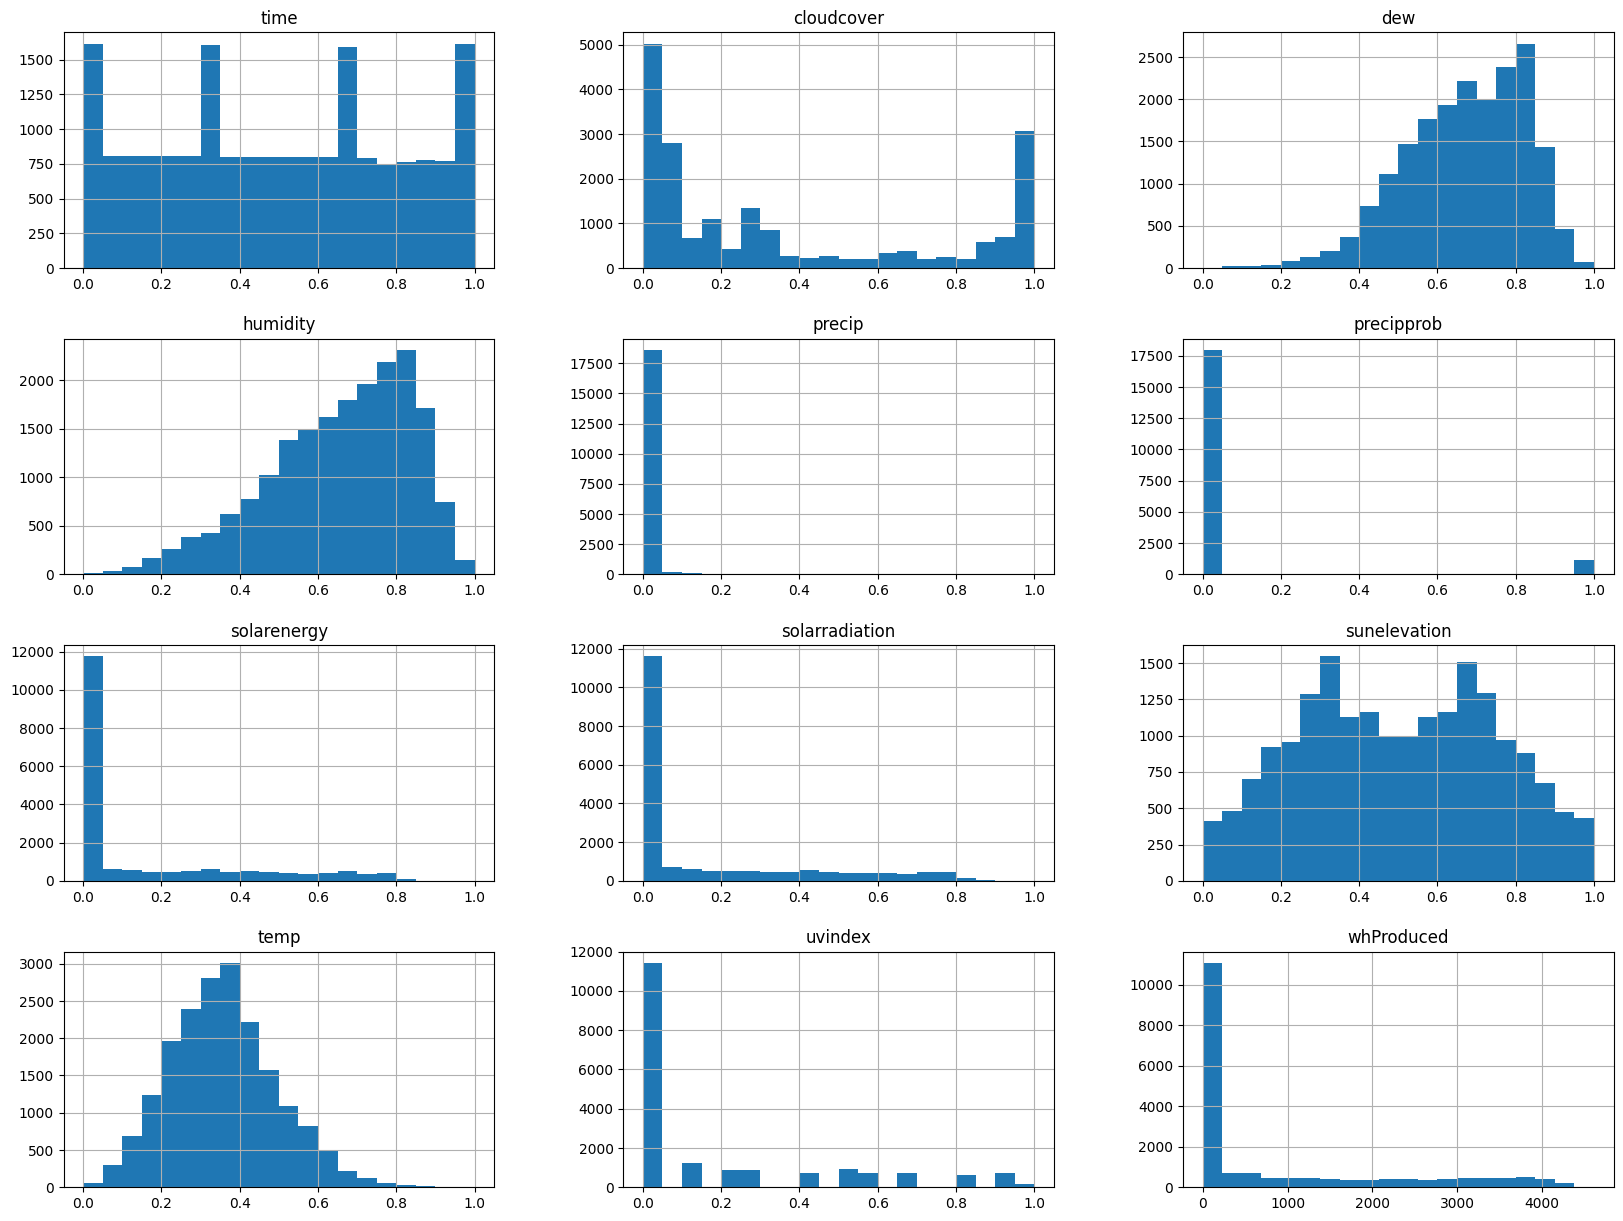

In [299]:
## REMOVE

nomnomtesting = normalize_min_max(solar_data)
print(nomnomtesting.head(20))

nomnomtesting.hist(bins=20, figsize=(20,15))
plt.show()

### Outliers

In [9]:
### KEEP THIS

# Remove rows where whProduced an outlier
def remove_outliers(data):
  Q1 = data['whProduced'].quantile(0.25)
  Q3 = data['whProduced'].quantile(0.75)
  max = Q3 + 1.5 * (Q3 - Q1)
  min = Q1 - 1.5 * (Q3 - Q1)
  # Report number of outliers
  print("Number of outliers: ", data[(data['whProduced'] > max) | (data['whProduced'] < min)].shape[0])
  data = data.drop(data[data['whProduced'] > max].index)
  data = data.drop(data[data['whProduced'] < min].index)
  return data

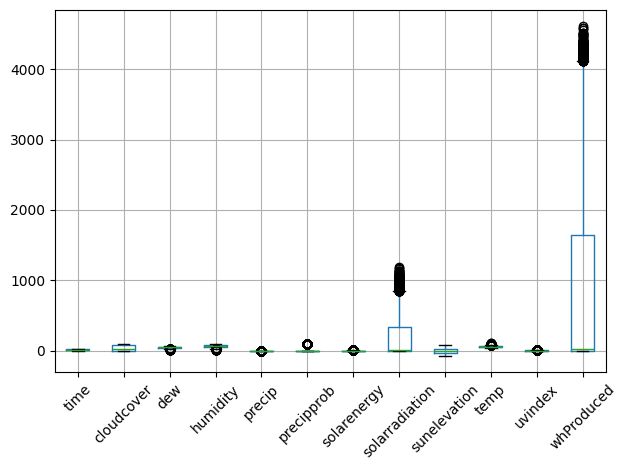

In [379]:
### KEEP THIS

solar_data.boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of outliers:  271


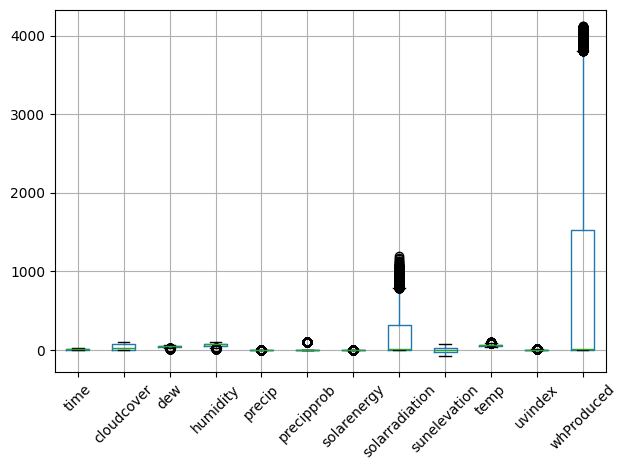

In [318]:
remove_outliers(solar_data).boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [192]:
## REMOVE

def outliers(data):
  # Calculate the first quartile (Q1) and third quartile (Q3)
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  #print(Q1)
  #print(Q3)
  # Calculate the interquartile range (IQR)
  IQR = Q3 - Q1

  # Define a multiplier for the IQR to determine the outlier threshold
  threshold_multiplier = 1.5  # You can adjust this multiplier based on your dataset and requirements

  # Define lower and upper bounds for outlier detection
  lower_bound = Q1 - threshold_multiplier * IQR
  upper_bound = Q3 + threshold_multiplier * IQR

  # Find indices of outliers
  outlier_indices = ((data < lower_bound) | (data > upper_bound)).any(axis=1)

  # Remove outliers from the training set and corresponding target variable
  data = data[~outlier_indices]

  print(outlier_indices)
  # Print the number of outliers removed
  num_outliers_removed = np.sum(outlier_indices)
  print("Number of outliers removed:", num_outliers_removed)

  return data

outliers(solar_data)

0        False
1        False
2        False
3        False
4        False
         ...  
19359    False
19360    False
19361    False
19362     True
19363     True
Length: 19364, dtype: bool
Number of outliers removed: 3070


,time,cloudcover,dew,humidity,precip,precipprob,solarenergy,solarradiation,sunelevation,temp,uvindex,whProduced
0,0.939024,-0.225994,-0.091635,0.228419,-0.141867,-0.252548,-0.481004,-0.453383,0.131160,-0.342714,-0.310611,-0.637610
1,1.083481,-0.551310,-0.199267,0.535764,-0.141867,-0.252548,-0.577733,-0.620179,-0.168563,-0.631817,-0.656263,-0.649860
2,1.227939,-0.739093,0.051874,1.108488,-0.141867,-0.252548,-0.577733,-0.668828,-0.478990,-0.724743,-0.656263,-0.649860
3,1.372396,-0.739093,-0.175349,1.180078,-0.141867,-0.252548,-0.577733,-0.668828,-0.797446,-0.962221,-0.656263,-0.649860
4,1.516853,-0.551310,-0.091635,1.408427,-0.141867,-0.252548,-0.577733,-0.668828,-1.115902,-1.003522,-0.656263,-0.649860
...,...,...,...,...,...,...,...,...,...,...,...,...
19357,-0.505548,-0.969195,-0.127512,1.098613,-0.141867,-0.252548,-0.674462,-0.644504,0.131160,-0.879620,-0.656263,-0.090668
19358,-0.361091,-0.969195,-0.079676,0.611057,-0.141867,-0.252548,-0.190816,-0.213613,0.446940,-0.569867,-0.310611,0.735869
19359,-0.216634,-0.744383,0.135588,0.201881,-0.141867,-0.252548,0.389559,0.370175,0.762720,-0.115561,0.380691,1.419006
19360,-0.072176,-0.744383,0.099711,-0.243091,-0.141867,-0.252548,1.260122,1.259757,1.073147,0.163217,1.417645,1.839120


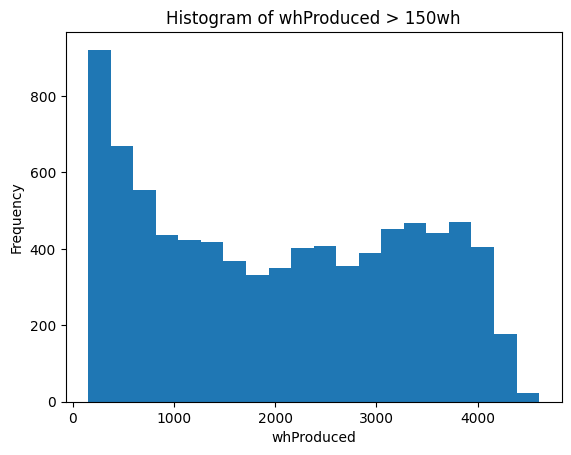

In [319]:
filtered_data = solar_data[solar_data['whProduced'] > 150]
plt.hist(filtered_data['whProduced'], bins=20)
plt.xlabel('whProduced')
plt.ylabel('Frequency')
plt.title('Histogram of whProduced > 150wh')
plt.show()

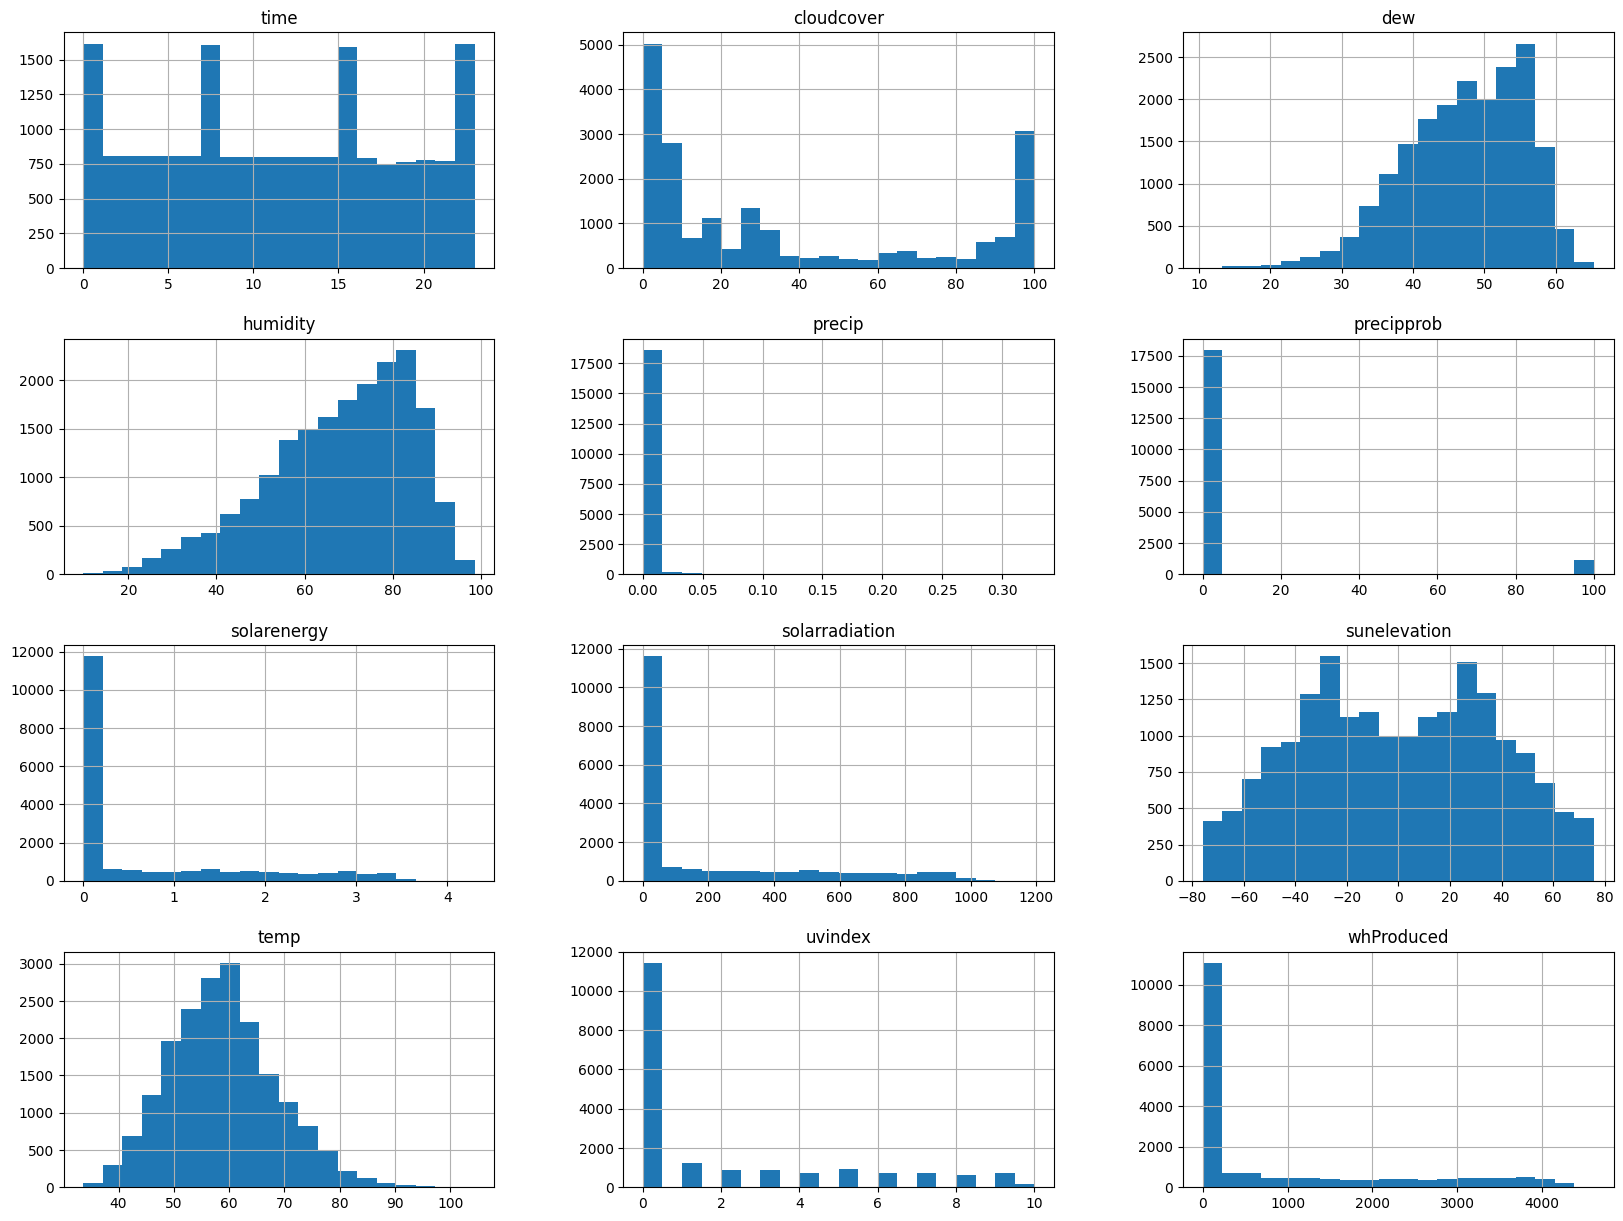

In [10]:
### KEEP THIS

# Plot histograms for each of the features
solar_data.hist(bins=20, figsize=(20,15))
plt.show()

### Correlation

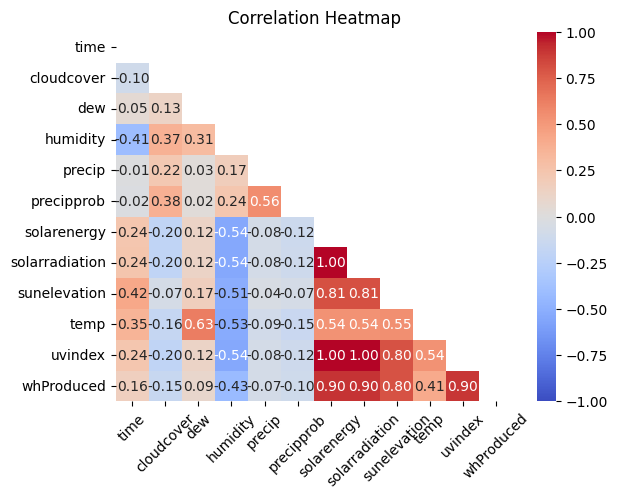

In [369]:
### KEEP THIS

def correlation_heatmap(data):
  # Calculate the correlation matrix
  corr = data.corr()
  # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its top-left to bottom-right
  mask = np.triu(np.ones_like(corr, dtype=bool))
  # Create the heatmap
  sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.title('Correlation Heatmap')
  plt.show()

correlation_heatmap(solar_data)

In [ ]:
### KEEP THIS

# Drop unwanted columns
def drop_columns(data, columns):
  data = data.drop(columns, axis=1)
  return data

In [ ]:
## REMOVE
def select_ideal_features(df, target_variable, threshold):
    # Compute correlations
    correlations = df.corr()[target_variable].abs().sort_values(ascending=False)
    print(correlations)
    
    # Select features with correlation above the threshold
    selected_features = correlations[correlations > threshold].index.tolist()
    
    # Remove the target variable from selected features
    selected_features.remove(target_variable)
    
    return selected_features

print(select_ideal_features(solar_data, 'whProduced', 0.5))

In [ ]:
## REMOVE

# Remove correlated features
def remove_correlated_features(data, threshold, target_variable):
  # Create correlation matrix
  corr_matrix = data.corr().abs()

  # Find features with correlation above threshold
  correlated_features = set()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i, j] > threshold:
        colname = corr_matrix.columns[i]
        correlated_features.add(colname)

   # Remove target variable from uncorrelated features
  correlated_features.discard(target_variable)

  # Print correlated features being removed
  print("Correlated features being removed: ", correlated_features)
  # Drop correlated features
  data = data.drop(correlated_features, axis=1)

  return data

# Remove highly correlated & uncorrelated features
'''
data: the input data
min: the minimum for uncorrelated features
max: the maximum for correlated features
target_variable: the target variable that we want to predict and should not be removed
'''
def remove_uncorrelated_features(data, min, max, target_variable):
  # Create correlation matrix
  corr_matrix = data.corr().abs()

  # Find features with correlation above threshold
  correlated_features = set()
  uncorrelated_features = set()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i, j] > max:
        colname = corr_matrix.columns[i]
        uncorrelated_features.add(colname)
      elif corr_matrix.iloc[i, j] < min:
        colname = corr_matrix.columns[i]
        uncorrelated_features.add(colname)

  # Remove target variable from uncorrelated features
  uncorrelated_features.discard(target_variable)

  # Print uncorrelated features being removed
  print("Uncorrelated features being removed: ", uncorrelated_features)
  # Drop uncorrelated features
  data = data.drop(uncorrelated_features, axis=1)

  return data


print(remove_uncorrelated_features(solar_data, -0.05, 0.05,'whProduced').head(10))

In [ ]:
corrmat = solar_data.corr()
plt.imshow(corrmat, cmap='coolwarm')
plt.colorbar(label = "correlation")
plt.xticks(range(len(corrmat)), corrmat.columns, rotation=45)
plt.yticks(range(len(corrmat)), corrmat.columns)
plt.suptitle("Correlation matrix of Continuous Features")
plt.show()

## Models

### Linear Regression

In [12]:
### KEEP THIS
def polynomial_regression(degree, data, folds, test_size, target_name, random_state=None):
    # Split the data into features and target variable
    X = data.drop(target_name, axis=1).values
    y = data[target_name].values

    # Define number of folds for cross-validation
    kf = KFold(folds)

    # Initialize lists to store results
    variances = []
    biases = []
    total_error = []
    models = []

    # Set the polynomial degree of the model
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)

    # Perform cross-validation
    for train_index, test_index in kf.split(X_poly):
        # Split data into training and testing sets for this fold
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate variance and R^2 for this fold
        variance = np.mean((np.mean(y_pred) - y_pred) ** 2)
        bias2 = np.mean((np.mean(y_pred) - y_test) ** 2)

        # Append results to lists
        variances.append(variance)
        biases.append(bias2)
        total_error.append(bias2 + variance)
        models.append(model)

        # Print results for this fold
        # print("Variance: {:.4f}, Bias2: {:.4f}, Total error: {:.4f}".format(variance, bias2, bias2 + variance))

    min_error_index = np.argmin(total_error)
    best_model = models[min_error_index]
    print("Selected model's Total reducible error:{}".format(total_error[min_error_index]))


    # Testing the final model on the test data
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=42)
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return best_model, mse, total_error[min_error_index], y_test, y_pred


# Example usage:
# best_model, mse_scores, total_error, y_test, y_pred = polynomial_regression(degrees, solar_data, folds, test_size=0.25, random_state=None)

In [15]:
### KEEP THIS

# call the function
best_model, mse, total_error, y_test, y_pred = polynomial_regression(2, solar_data, 5, 0.25, 'whProduced', None)

print("Mean Squared Error: ", mse)
print("Total reducible error: ", total_error)

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### KEEP THIS


ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
### KEEP THIS
# Linear Regression Model
class LinearRegression:
    def __init__(self):
        self.theta = None
    def fit(self, X, y, lr=0.01, epochs=20, batch_size=None, verbose=True):
        self.theta = np.random.randn(X.shape[1])
        m = X.shape[0]
        loss_history = []

        for epoch in range(epochs):
            num_batches = m // batch_size if batch_size else 1
            # Iterate over the batches in each epoch
            for batch in range(num_batches):
                # If a batch_size is provided, it means to perform mini-batch gradient descent, where the training dataset is divided into smaller batches, and each batch is used to update the model's parameters.
                if batch_size:
                    #This line generates random indices from 0 to m (the total number of samples in the training set) without replacement. m is the size of the training dataset. The number of indices generated is equal to the batch_size.
                    indices = np.random.choice(m, batch_size)
                    # creates a mini-batch of input features for training
                    X_batch = X[indices]
                    # selects the corresponding subset of y for the mini-batch of input features
                    y_batch = y[indices]
                else:
                    # performing full-batch-gradient descent 
                    X_batch = X
                    y_batch = y
                # generating the predictions on X_batch
                y_pred = X_batch.dot(self.theta)
                error = y_pred - y_batch
            
                # computing the gradient of the loss function
                gradient = 2 * X_batch.T.dot(error) 
                avg_gradient = sum(gradient)/ X_batch.shape[0]
            
                # updating the weights with the computed gradient
                self.theta -= lr * avg_gradient

            # print the Mean Squared Error (MSE) and store it in the loss_history list at certain intervals during the training process. 
            
            y_train_pred = X.dot(self.theta)
            mse = mean_squared_error(y, y_train_pred)
            loss_history.append(mse)
                
        
        return loss_history
    



'''
Gradient Descent
input_data: the input data
lr: the learning rate
epochs: the number of epochs
test_size: the test size
batch_size: the batch size
'''
def Gradient_descent(input_data, lr=0.01, epochs=20, test_size=0.25, batch_size=None):
    X = input_data.data
    y = input_data.target

    # Spliting the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size, random_state=42)
    # Stansdardizing the attributes of the Dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add the column of 1 values to X
    X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

    # Create an instance of the LinearRegression class
    model = LinearRegression()
    # Fit the model on the training set
    loss_history = model.fit(X_train_scaled, y_train, lr, epochs, batch_size)
    
    # Model Evaluation
    def evaluate_model(model, X_test, y_test):
        y_pred = X_test.dot(model.theta)
        mse = mean_squared_error(y_test, y_pred)
        return mse
    
    mse = evaluate_model(model, X_test_scaled, y_test)

    return model, mse, loss_history

# Example usage:
##### BGD #####
# model, mse, loss_history = Gradient_descent(boston, lr=0.01, epochs=20, test_size=0.25, batch_size=None)
##### SGD ####
# model, mse, loss_history = Gradient_descent(boston, lr=0.01, epochs=20, test_size=0.25, batch_size=1)

In [ ]:
data, lr=0.01, epochs=20):
    X = data.data
    y = housing_data.target
    print("dataset size:{}".format(X.shape[0]))

    # Spliting the dataset into train and test sets [80:20]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Stansdardizing the attributes of the Dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add the column of 1 values to X
    X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
    theta = np.random.randn(X.shape[1])
    m = X.shape[0]
    loss_history = []

    for epoch in range(epochs):
        y_pred = X.dot(theta)
        error = y_pred - y
        gradient = 2 * X.T.dot(error) / m
        theta -= lr * gradient

        mse = mean_squared_error(y, y_pred)
        loss_history.append(mse)

    return theta, loss_history

MSE: 261796.18730092872
R^2: 0.8485812347524049


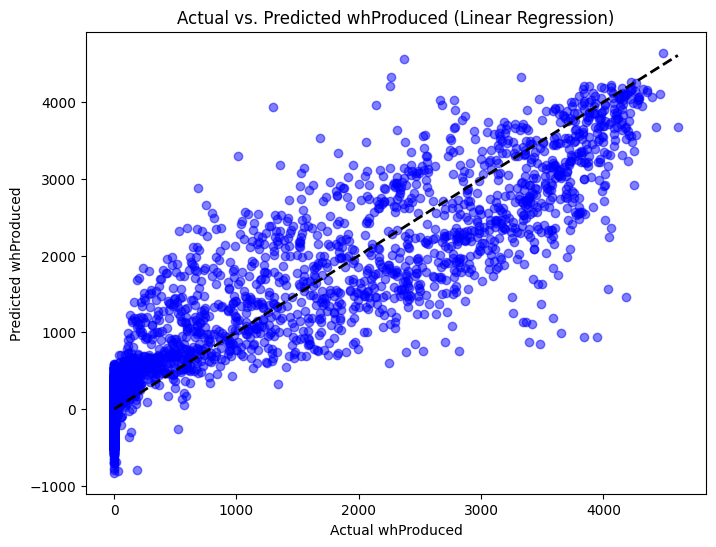

Bias: 1.6122456077304006
Variance: 1482256.664808898


In [73]:
## OLD CODE
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2:", r2)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Linear Regression)')
plt.show()

mean_predicted = np.mean(y_pred)
mean_true = np.mean(y_test)

# Bias
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2) # 1.6122456077304006
# bias = mean_squared_error(y_test, y_pred)

# Variance
variance = np.var(y_pred)
# variance = np.mean((np.mean(y_test) - y_test) ** 2) # 1728954.7096282812

print("Bias:", bias)
print("Variance:", variance)



In [74]:
# predict on a row
print(model.predict(X_test.iloc[[16]]))

[-403.51828743]


### Polynomial Regression

Mean Squared Error: 106869062.61091073
R-squared: -60.81137193228572


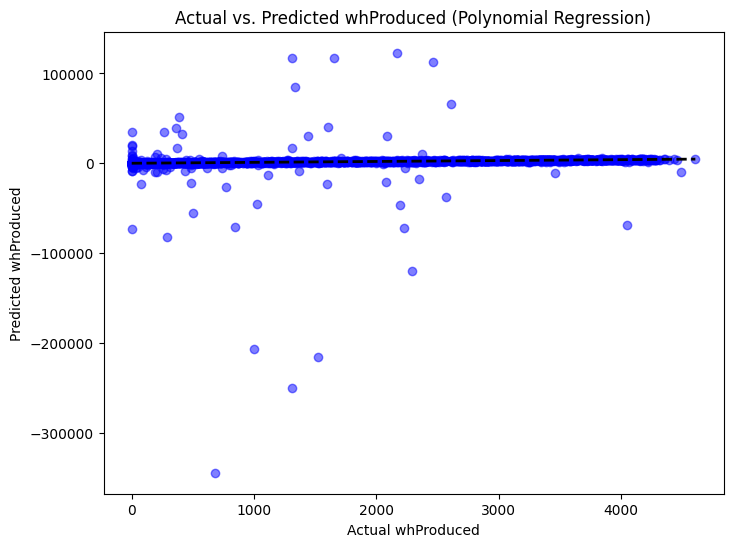

Bias: 1.6122456077304006
Variance: 108282099.45413786


In [75]:
degree = 5  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()
# bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)

# Variance
# variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Bias:", bias)
print("Variance:", variance)

Mean Squared Error: 17049484.352634113
R-squared: -8.861151514084305


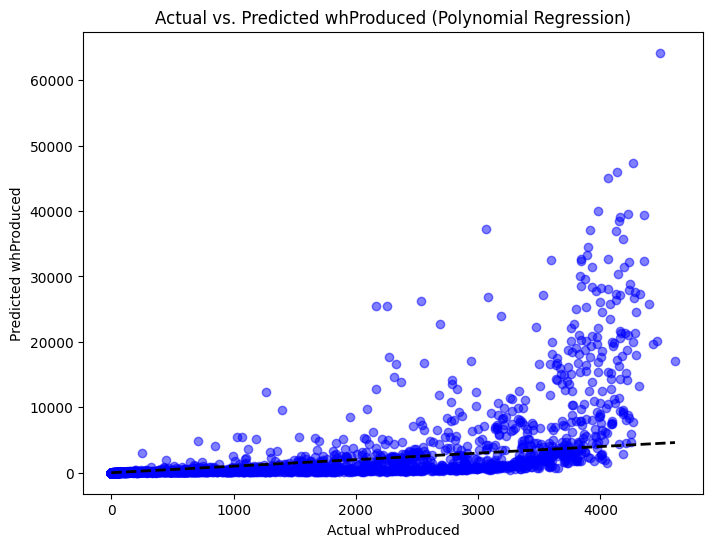

Bias: 1.6122456077304006
Variance: 22467597.87311977


In [76]:
degree = 2  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
#model = LinearRegression()
#model.fit(X_train_poly, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test_poly)

# Transform the target variable
y_train_transformed = np.log1p(y_train)

# Train the model on the transformed data
model.fit(X_train, y_train_transformed)

# Predict the transformed values
y_pred_transformed = model.predict(X_test)

# Apply the inverse transformation to get the final predictions
y_pred = np.expm1(y_pred_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()

# Bias
#bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)
print("Bias:", bias)

# Variance
#variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Variance:", variance)

In [77]:
# predict on a row
# print(model.predict(X_train_poly[[18]]))
# print(model.predict(solar_data.iloc[[16]].drop(columns=['whProduced'])))

### Deep Neural Network

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
'''
This function makes a DNN model
'''

def DNN(data, target_variable, test_size, model, random_state=None, epochs=100, batch_size=32):
  # Split the data into features and target variable
  X = data.drop(target_variable, axis=1).values
  y = data[target_variable].values

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

  # Evaluate the model
  mse = model.evaluate(X_test, y_test)
  r2 = r2_score(y_test, model.predict(X_test))

  bias2 = np.mean((np.mean(model.predict(X_test)) - model.predict(X_test)) ** 2)
  variance = np.var(model.predict(X_test))
  total_error = (bias2 + variance)

  y_pred = model.predict(X_test)

  return model, mse, r2, total_error, y_test, y_pred

def DNN_dataSplit(data, target_variable, test_size, random_state=None):
  # Split the data into features and target variable
  X = data.drop(target_variable, axis=1).values
  y = data[target_variable].values

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  return X_train, X_test, y_train, y_test

In [16]:
# Run the DNN function
input_shape = solar_data.shape[1] - 1

layers = [
    Dense(128, activation='relu', input_shape=input_shape),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
]

model, mse, r2, total_error, y_test, y_pred = DNN(solar_data, 'whProduced', 0.25, layers, random_state=42)

NameError: name 'solar_data' is not defined

Epoch 1/100
383/383 [==============================] - 0s 678us/step - loss: 929939.0625 - val_loss: 234824.6094
Epoch 2/100
383/383 [==============================] - 0s 578us/step - loss: 183082.5312 - val_loss: 148487.7969
Epoch 3/100
383/383 [==============================] - 0s 577us/step - loss: 126463.9766 - val_loss: 112123.1016
Epoch 4/100
383/383 [==============================] - 0s 586us/step - loss: 105045.9375 - val_loss: 99578.0156
Epoch 5/100
383/383 [==============================] - 0s 578us/step - loss: 98244.5938 - val_loss: 97045.8047
Epoch 6/100
383/383 [==============================] - 0s 596us/step - loss: 95366.7031 - val_loss: 94184.3438
Epoch 7/100
383/383 [==============================] - 0s 584us/step - loss: 93019.7812 - val_loss: 90869.1250
Epoch 8/100
383/383 [==============================] - 0s 589us/step - loss: 91336.2891 - val_loss: 90535.5234
Epoch 9/100
383/383 [==============================] - 0s 568us/step - loss: 90880.7891 - val_loss: 93338

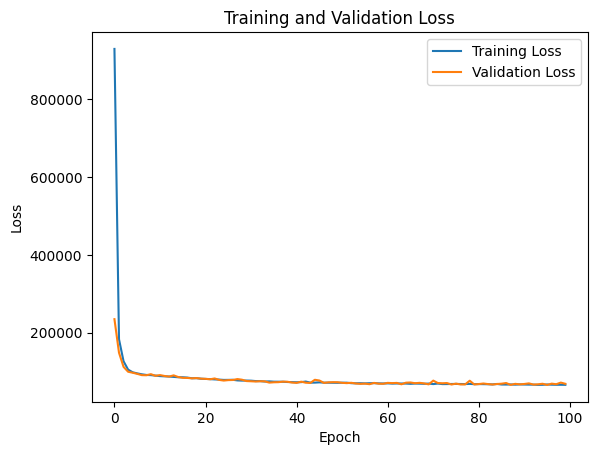

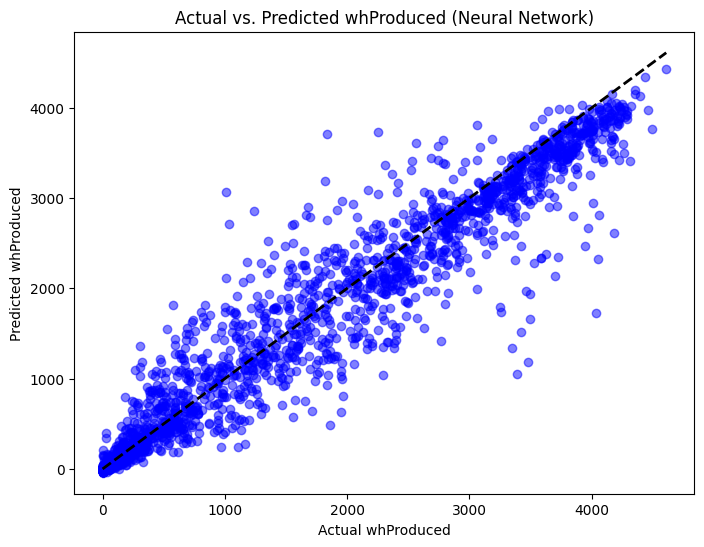

Bias: 1728956.3218738888
Variance: 1553609.2


In [78]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Neural Network)')
plt.show()

bias = np.mean((mean_predicted - y_test) ** 2)

# Variance
variance = np.mean((y_pred - mean_predicted) ** 2)
print("Bias:", bias)
print("Variance:", variance)

# Transformation of skewed data

import numpy as np
import matplotlib.pyplot as plt

skewed_data=y


/Users/christopher/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christopher/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 8.435766192720509] is not finite

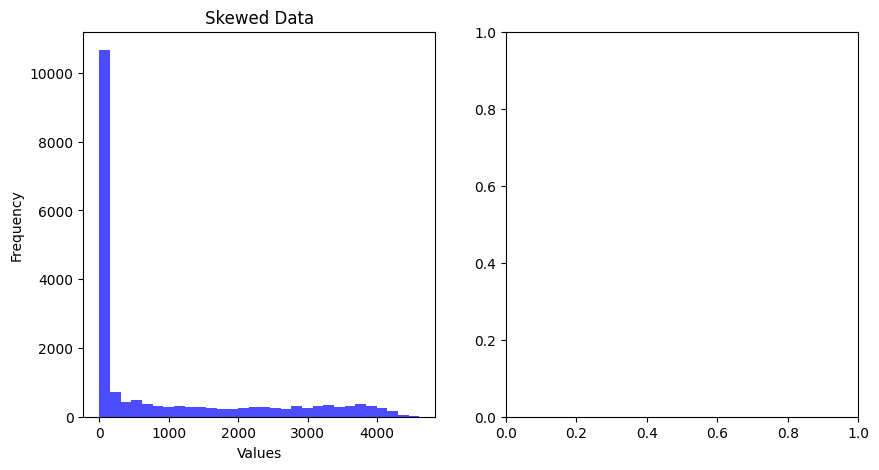

In [79]:
# Plot the histogram of skewed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(skewed_data, bins=30, color='blue', alpha=0.7)
plt.title('Skewed Data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Apply transformations
log_transformed = np.log(skewed_data)
sqrt_transformed = np.sqrt(skewed_data)
inverse_transformed = 1 / skewed_data
exp_transformed = np.exp(skewed_data)

# Plot histograms of transformed data
plt.subplot(1, 2, 2)
plt.hist(log_transformed, bins=30, color='green', alpha=0.7, label='Log Transformation')
plt.hist(sqrt_transformed, bins=30, color='red', alpha=0.7, label='Square Root Transformation')
plt.hist(inverse_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')
plt.hist(exp_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')

plt.title('Transformed Data')
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

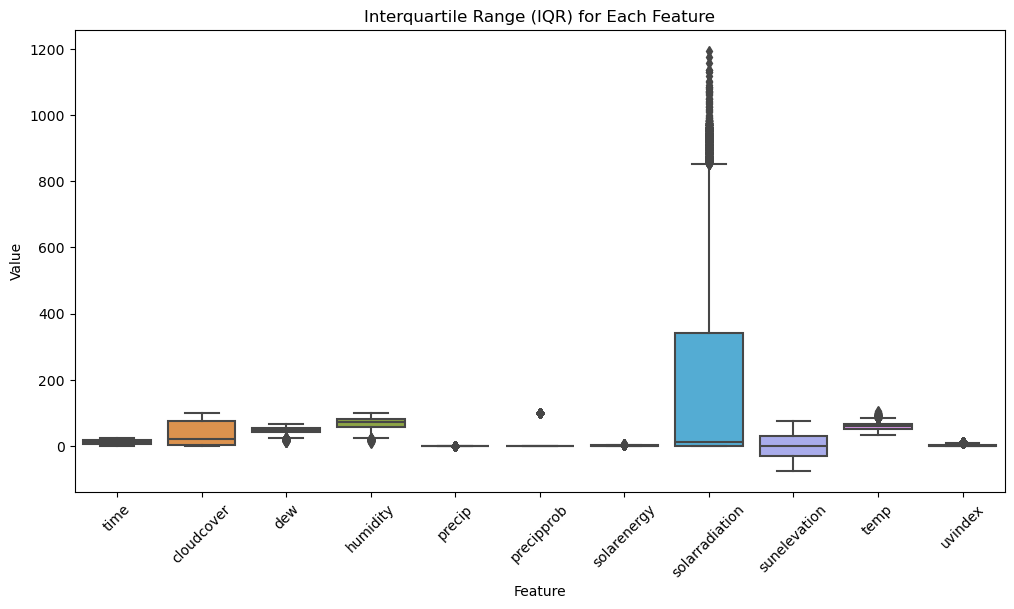

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.title('Interquartile Range (IQR) for Each Feature')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

# Experiments